# Using Tabula Sapiens as a reference for annotating new datasets

This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference. 

Initial setup: 
1. Make sure GPU is enabled (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)
2. We also highly recommend getting Colab PRO for access to a high ram session.


Integration Methods Provided:
- scVI [(Lopez et al. 2018)](https://www.nature.com/articles/s41592-018-0229-2)
- bbKNN [(Polański et al. 2020)](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
- Scanorama [(He et al. 2019)](https://www.nature.com/articles/s41587-019-0113-3)

Annotation Methods:
- KNN on integrated spaces
- scANVI [(Xu et al. 2021)](https://www.embopress.org/doi/full/10.15252/msb.20209620)
- onClass [(Wang et al. 2020)](https://www.biorxiv.org/content/10.1101/810234v2)
- Celltypist [(Dominguez Conde et al. 2022)](https://www.science.org/doi/10.1126/science.abl5197)
- SVM 
- RandomForest

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

**User action is only required in Steps 1-3.**

Last edited: 6/27/2021



## Step 1: Setup environment

We omit the output of those lines for readability.

In [1]:
%%capture
clone_github_repo = False # Set to True if running outside of already exisiting Github repository.
if clone_github_repo:
    !git clone --quiet https://github.com/czbiohub/PopV.git

# Restart the Runtime after installation (User Action Required)

Runtime -> "Restart runtime"

In [2]:
%%capture
# Restart the runtime before running this cell
import popv
import numpy as np
import scanpy as sc
import os

2023-01-30 14:09:03.575261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 14:09:05.654468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-30 14:09:05.654668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-30 14:09:05.654687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

# Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [4]:
input_file ={'source': 'wget', 'path': 'tmp_testing/LCA.h5ad', 'link': 'https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1'}

if input_file['source']== 'gdrive':
  # OPTION 1: Connect to Google Drive
  # This is the recomended method especially for large datasets
  from google.colab import drive    
  drive.mount('/content/drive')
  query_adata = sc.read(input_file['path'])
elif input_file['source'] == 'local':
  # OPTION 2: Uploading data manually
  # Click the folder icon on the left navigation bar, and select the upload icon
  # Note: Manually uploaded data is automatically deleted when the colab session ends
  # This is not recommended if your dataset is very large
  query_adata = sc.read(input_file['path'])
else:
  # OPTION 3: Downloading from the cloud (Dropbox, AWS, Google Drive, etc)
  # Google Colab supports wget, curl, and gdown commands
  # It is recommended to download the data into Google Drive and read from there.
  # This way your data will be persistent.
  print('downloading')
  try:
    !wget -O {input_file['path']} {input_file['link']}
    query_adata = sc.read(input_file['path'])
  except:
    raise Exception(f'Default download failed with wget. Use custom downloader or check provided link ' + input_file['link'])
    
query_adata.obs_names_make_unique()
query_adata.var_names = query_adata.var_names.str.upper()
# query_adata = query_adata[np.random.choice(query_adata.obs_names, 1000, replace=False)]

downloading
--2023-01-29 22:58:11--  https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/mrf8y7emfupo4he/LCA.h5ad [following]
--2023-01-29 22:58:11--  https://www.dropbox.com/s/dl/mrf8y7emfupo4he/LCA.h5ad
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc15bd712a7e931932215ae55df3.dl.dropboxusercontent.com/cd/0/get/B1i7TwDtliy5sJ2sgqsFuzqo-leIV_KKXNFzrazCVDR75AuLVpvzMFsqs65FPwjPSliE0_acnvHFbEy0CL54BV_tgROkFWOIJiHyJKFmdAQiF6s-KodfhtNTcgnUoRgNuVDSkTrvQwq83Ij8hJn88_f7tBIoayPclInMwFDiobiyQ167S7ZiG9Qmv4i4aLGccrk/file?dl=1# [following]
--2023-01-29 22:58:11--  https://uc15bd712a7e931932215ae55df3.dl.dropboxusercontent.com/cd/0/get/B1i7TwDtliy5sJ2sgqsFuzqo-leIV_KKXNFzrazCVDR75AuLVpvzMFsqs

# Step 3 (User Action Required): Setting Up Annotation Parameters 

Here is where you set the parameters for the automated annotation.

Arguments:
- **tissue:** Tabula Sapiens tissue to annotate your data with. Available tissues: ["Bladder", "Blood", "Bone_Marrow", "Kidney", "Large_Intestine", "Lung","Lymph_Node", "Pancreas", "Small_Intestine", "Spleen", "Thymus","Trachea", "Vasculature"]
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction. 
- **algorithms:** these are the methods to run. By default, will run all methods.
Options: ["knn_on_scvi_pred", "scanvi_pred", "knn_on_bbknn_pred", "svm_pred", "rf_pred", "onclass_pred", "knn_on_scanorama_pred",


Lesser used parameters
- **query_labels_key**: scANVI has the option to use labeled cells in the query dataset during training. To use some prelabeled cells from the query dataset, set `query_labels_key` to the corresponding key in `query_adata.obs`
- **unknown_celltype_label**: If `query_labels_key` is not None, will treat everything not labeled `unknown_celltype_label` as a labeled cell

In [5]:
""" 
tissue options: 
['Bladder','Blood','Bone_Marrow','Fat',
'Heart','Kidney','Large_Intestine','Liver',
'Lung','Lymph_Node','Mammary','Muscle',
'Pancreas','Prostate','Salivary Gland',
'Skin','Small_Intestine','Spleen',
'Thymus','Trachea','Vasculature']
"""
output_folder = 'tmp_testing'
tissue = 'Lung'
save_folder = f'{output_folder}/popv_results'

query_batch_key = 'donor_method'
algorithms = None

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Step 4: Downloading Reference Data and Pretrained Models
No more user input required! Just run all the following code blocks.

**NOTE: PopV has only been evaluated with the Lung/Thymus/Lymph_Node as a reference dataset. Different tissues have different annotation quality and the Tabula sapiens community is currently actively improving the annotation quality. We strongly expect improvement of cell annotation when the updated annotation is released. Upon release the Zenodo repository will be updated.**

In [6]:
import requests
res = requests.get("https://zenodo.org/api/records/7580683")
tissue_download_path = {ind['key'][3:-14]:ind['links']['self'] for ind in res.json()['files']}

In [7]:
refdata_url = tissue_download_path[tissue]
output_fn = f'{output_folder}/TS_{tissue}.h5ad'
if not os.path.exists(output_fn):
    !wget -O $output_fn $refdata_url

In [8]:
# read in the reference dataset
ref_adata = sc.read_h5ad(output_fn)
# ref_adata = ref_adata[np.random.choice(ref_adata.obs_names, 5000, replace=False)]

### Setup reference data

In [9]:
# Following parameters are specific to Tabula Sapiens dataset and contain the annotated cell-type and the batch_key that are corrected for during model training.
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [10]:
min_celltype_size = np.min(ref_adata.obs.groupby(ref_labels_key).size())
n_samples_per_label = np.max((min_celltype_size, 500))

### Preprocess query with ref dataset


In [11]:
ref_adata

AnnData object with n_obs × n_vars = 35672 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'

In [12]:
from popv.preprocessing import Process_Query

adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'{output_folder}/pretrained_models/',
        pretrained_scvi_path=None, #'tmp_testing/pretrained_models/scvi/',
        prediction_mode='retrain', # 'fast' mode gives fast results (does not include BBKNN and Scanorama and makes more inaccurate errors)
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=4000
    ).adata

In [13]:
adata

AnnData object with n_obs × n_vars = 110743 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'method', 'donor', 'cell_ontology_type', 'donor_method', 'cell_ontology_id', '_dataset', 'n_counts'
    var: 'n_counts', 'highly_variable', 'mean', 'std'
    uns: 'Filtered_cells', 'log1p', 'unknown_celltype_label', '_pretrained_scvi_path', '_save_path_trained_models', '_prediction_mode', '_cl_obo_file', '_cl_ontology_file', '_nlp_emb_file', '_use_gpu', '_compute_embedding', '_return_probabilities', 'prediction_keys'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'scvi_counts', 'scaled_counts'

# Step 5: Run Automated Cell Annotation Methods
No user action required. 

Your results will be saved to the folder you provided as **save_folder**.

All results are stored in adata.obs
- The column `popv_prediction` contains the end popv prediction. 
- `popv_prediction_score` contains the score for the popv_prediction, which is a measure of the number of methods that agreed with the resulting prediction. We use the cell ontology when aggregating results.
- We also include the majority vote, which simply takes the celltype that was most often predicted by the individual methods.

In [14]:
from popv.annotation import annotate_data
annotate_data(adata, save_path=f'{output_folder}/popv_output')

Found 4000 genes among all datasets
[[0.         0.07474291 0.38567323 0.00274977 0.70227833 0.00418799
  0.01678161 0.01754926 0.03918723 0.01683087 0.0099889 ]
 [0.         0.         0.04238776 0.50717996 0.06069727 0.72778036
  0.00528736 0.04564836 0.34687954 0.01680461 0.17536071]
 [0.         0.         0.         0.18484571 0.41308756 0.00604933
  0.06       0.08938994 0.15674891 0.04557329 0.03329634]
 [0.         0.         0.         0.         0.02260923 0.62819916
  0.00091659 0.01191567 0.39622642 0.00213871 0.07991121]
 [0.         0.         0.         0.         0.         0.09585854
  0.08528736 0.27176781 0.33381713 0.16464441 0.05327414]
 [0.         0.         0.         0.         0.         0.
  0.001396   0.04606794 0.50217707 0.01302932 0.15760266]
 [0.         0.         0.         0.         0.         0.
  0.         0.13448276 0.00580552 0.22436782 0.00221976]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.44992743 0.2

In [15]:
# Optional: save the full anndata will all objects
# adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

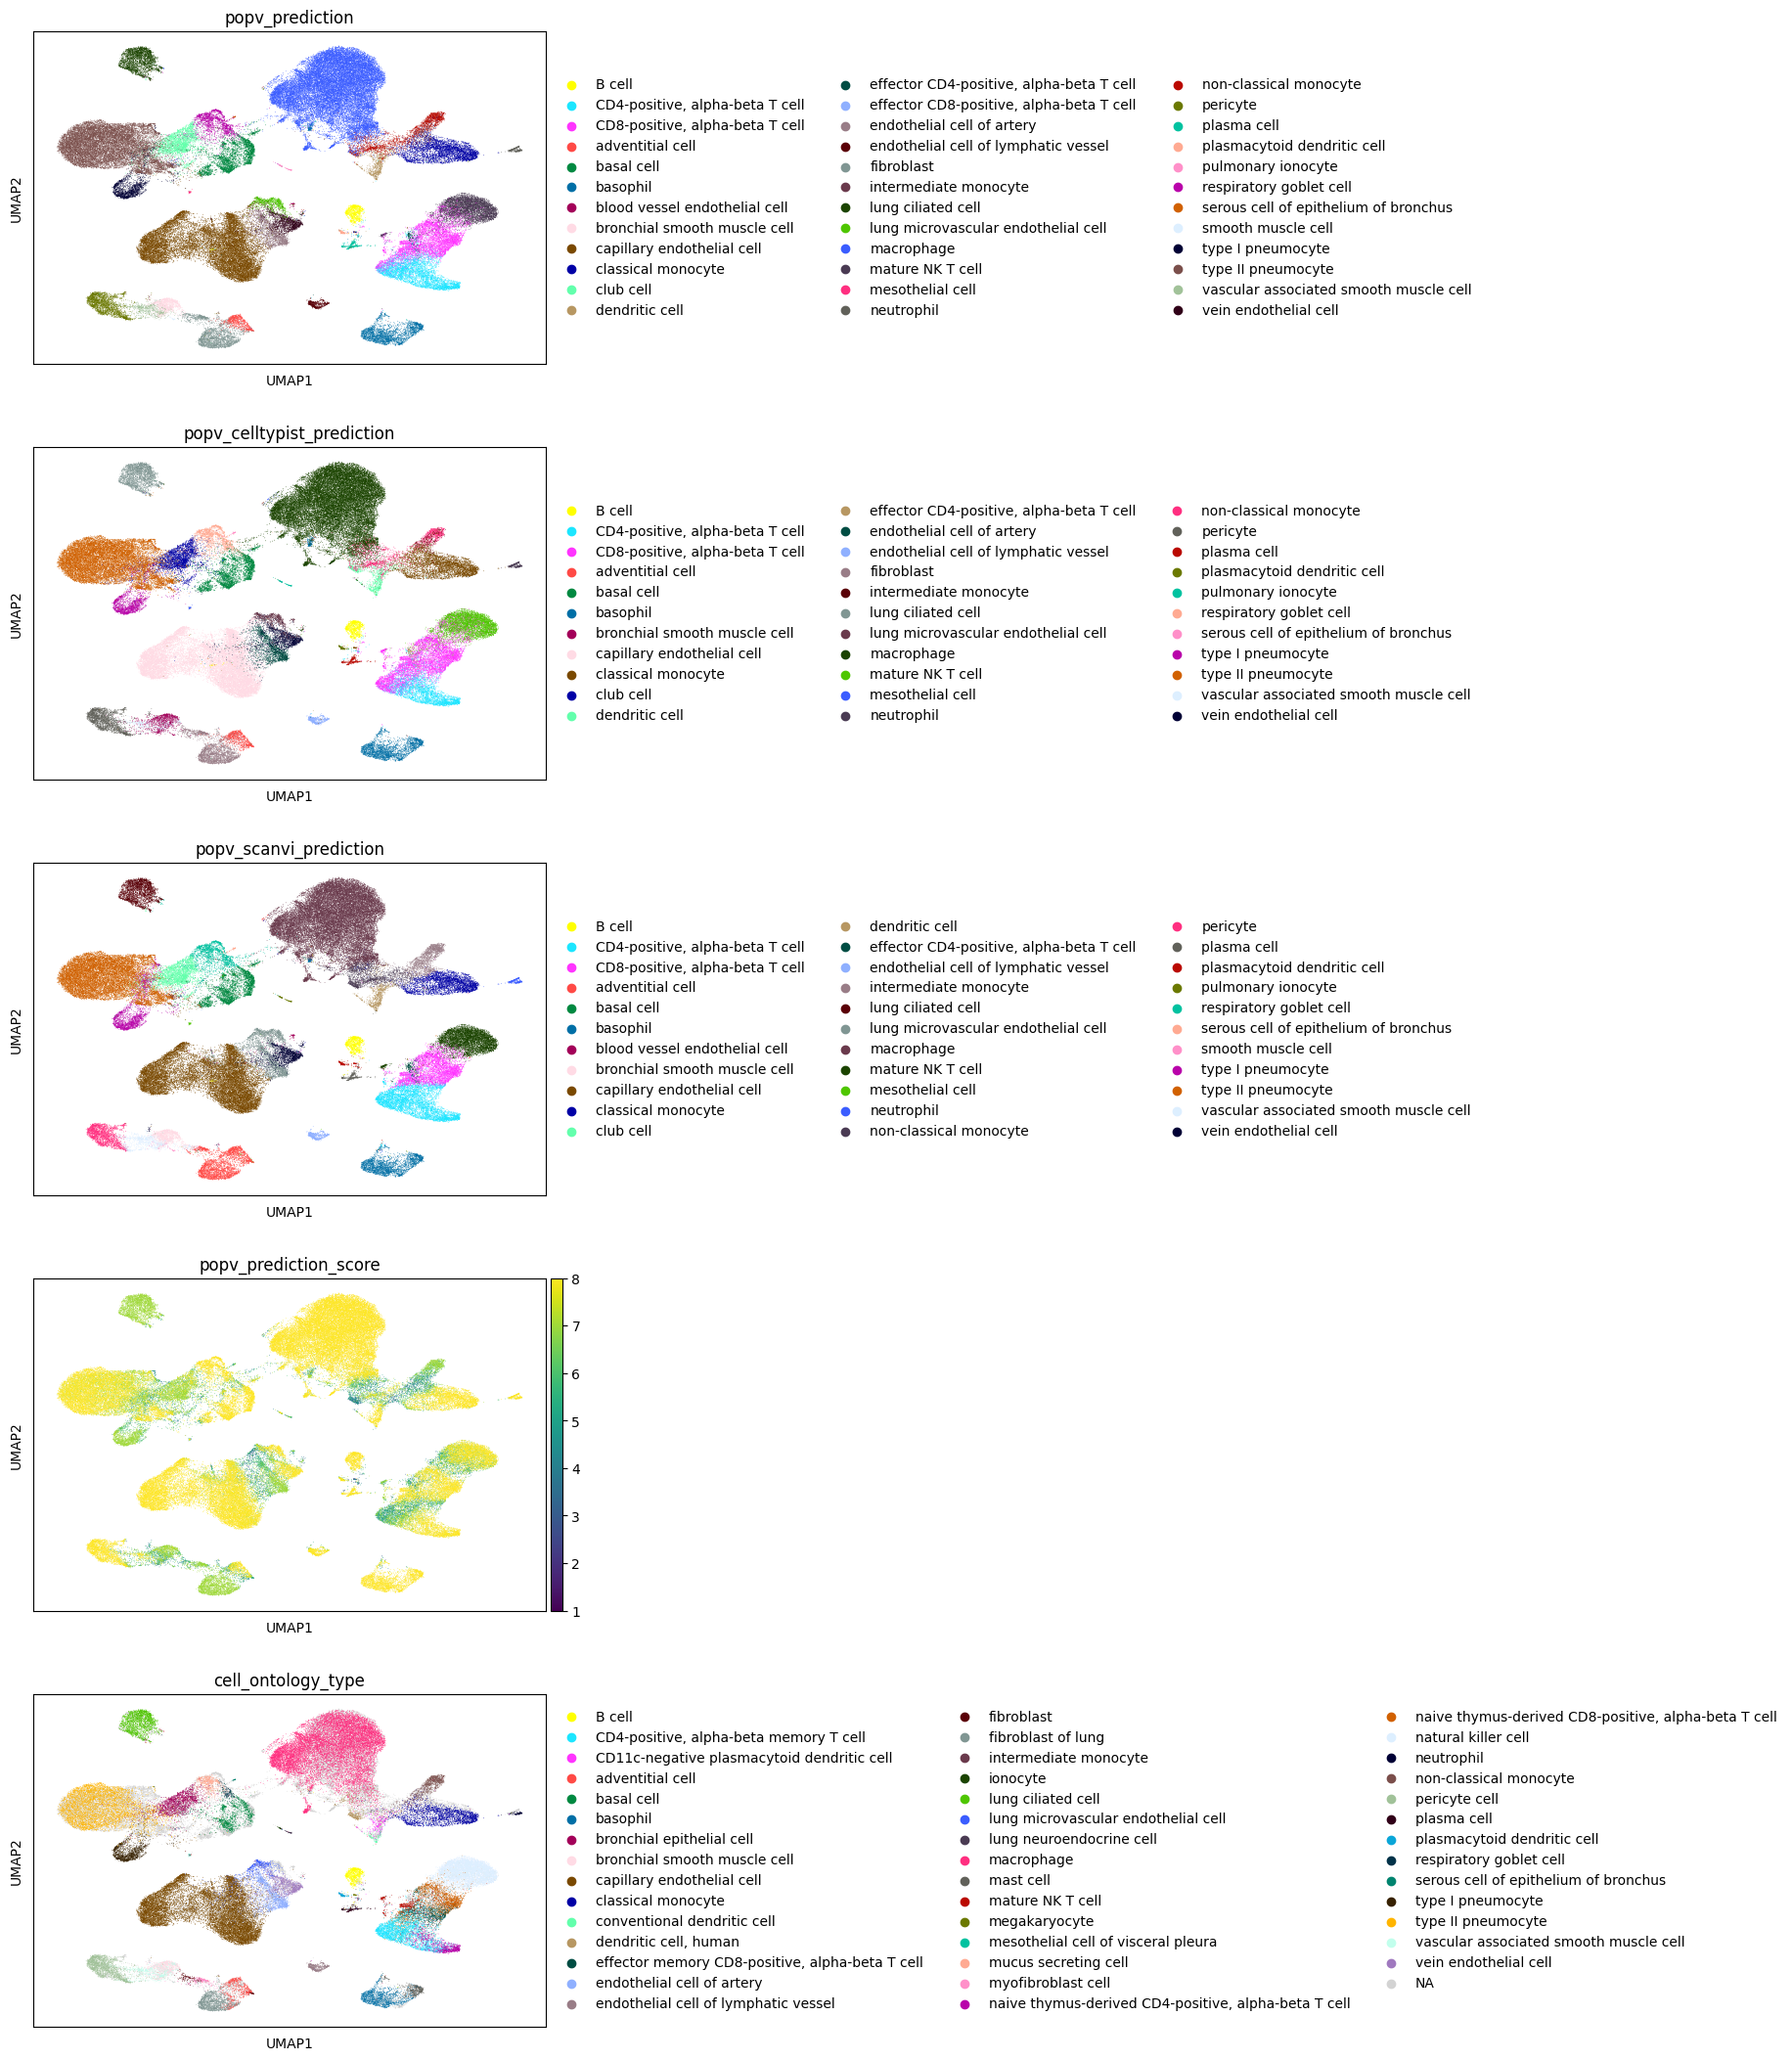

In [16]:
adata.obsm['X_umap'] = adata.obsm['X_scanvi_umap_popv']

sc.pl.umap(adata,
           color=['popv_prediction', 'popv_celltypist_prediction', 'popv_scanvi_prediction', 'popv_prediction_score', 'cell_ontology_type'], ncols=1)

# Step 6: Summary Statistics

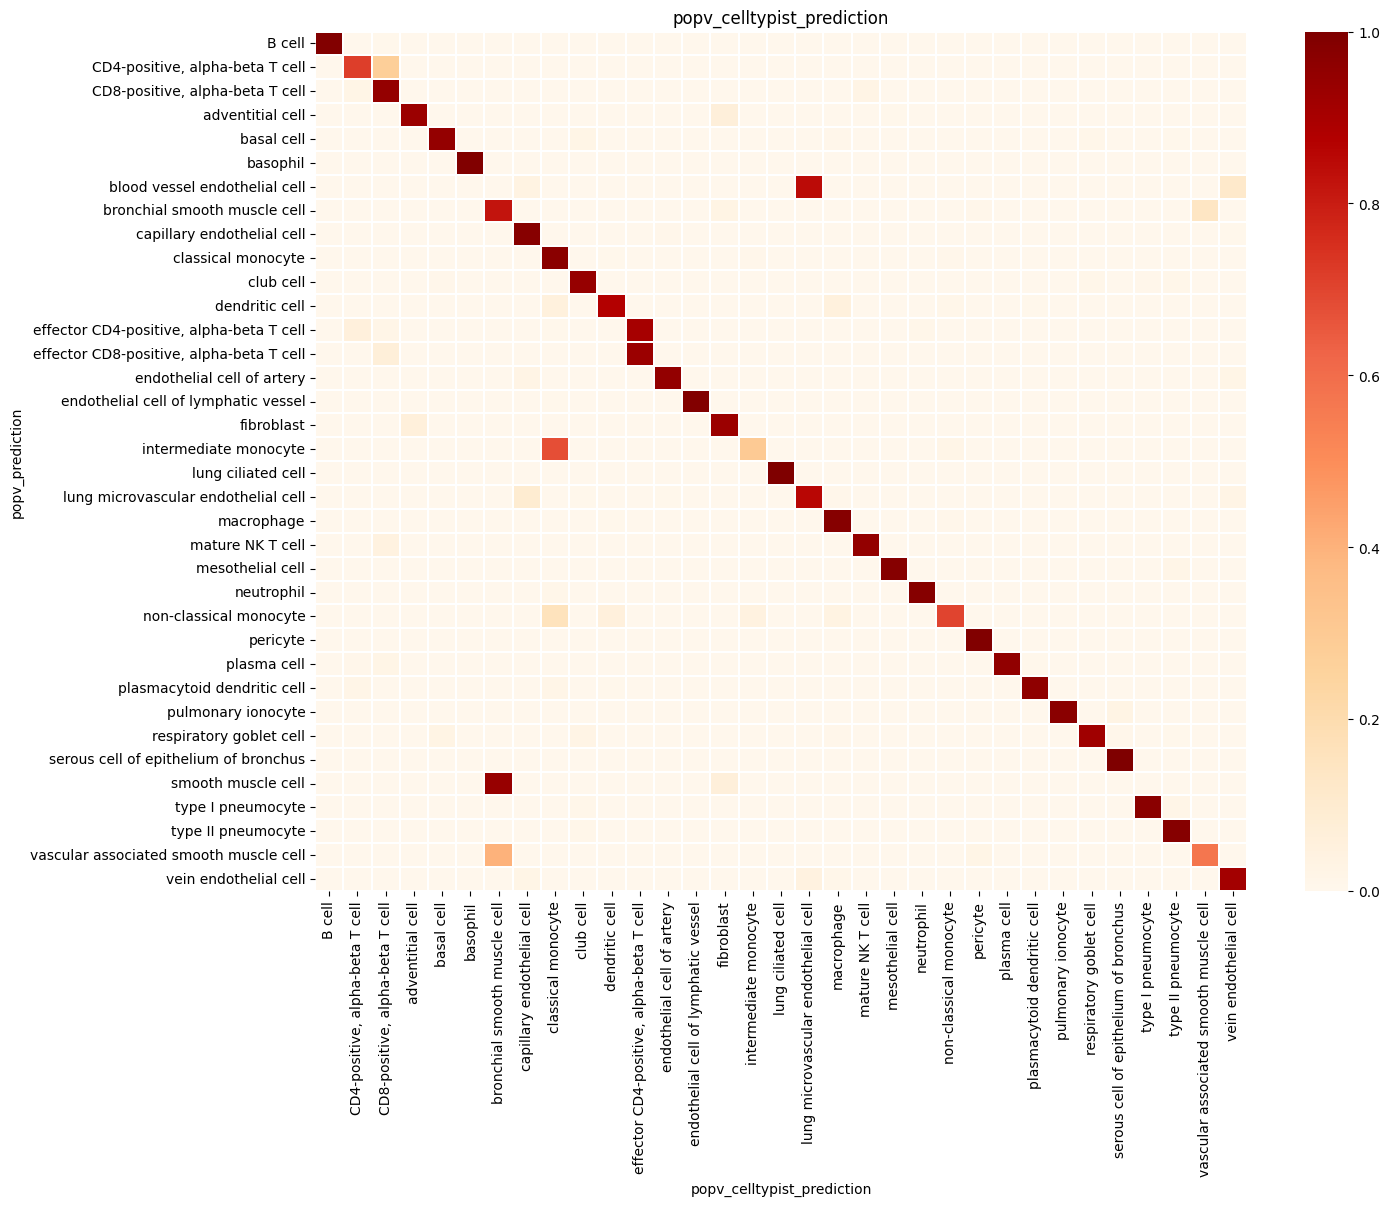

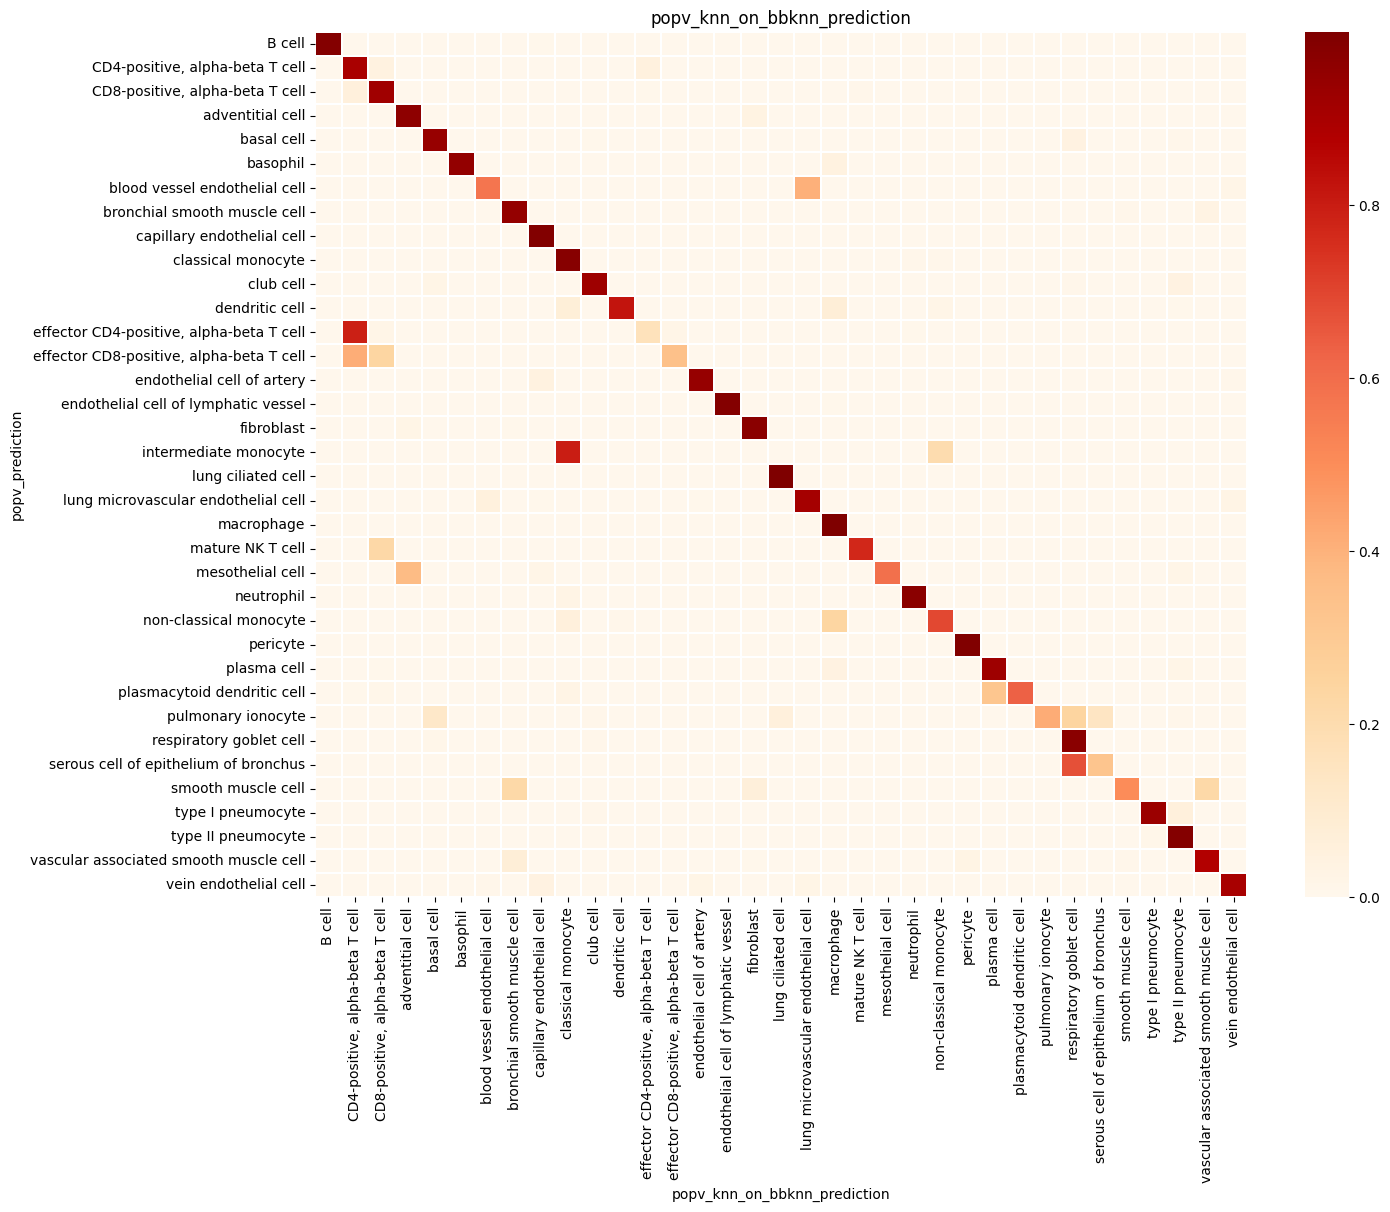

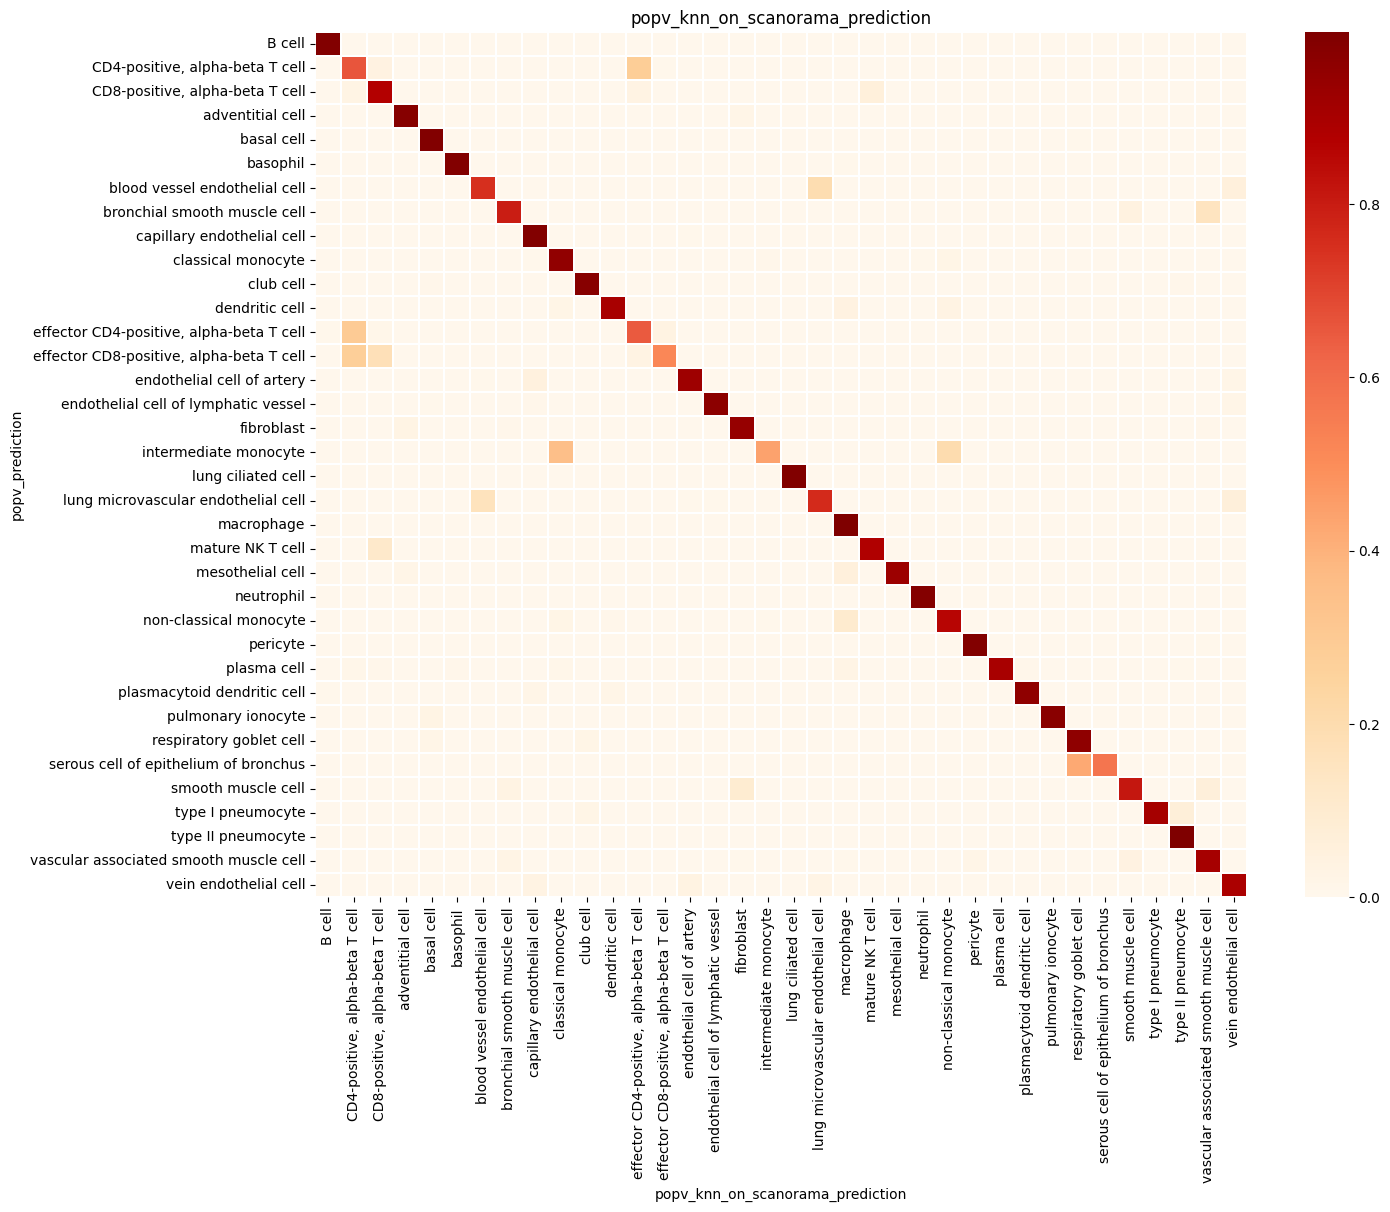

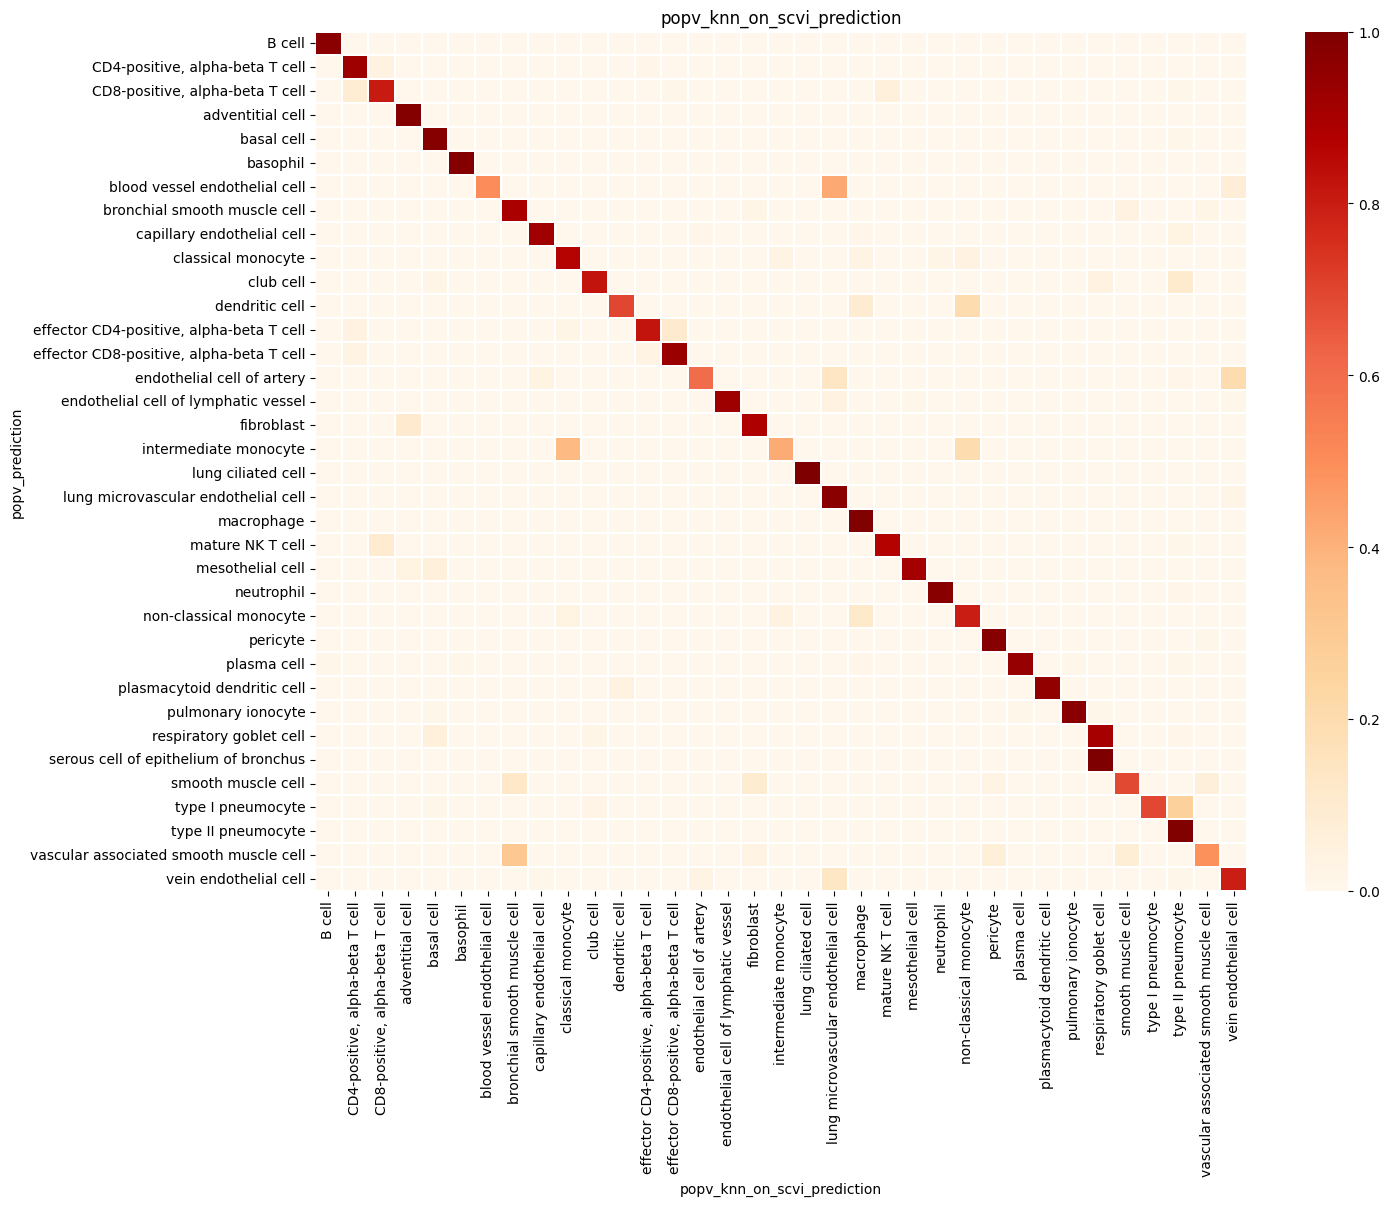

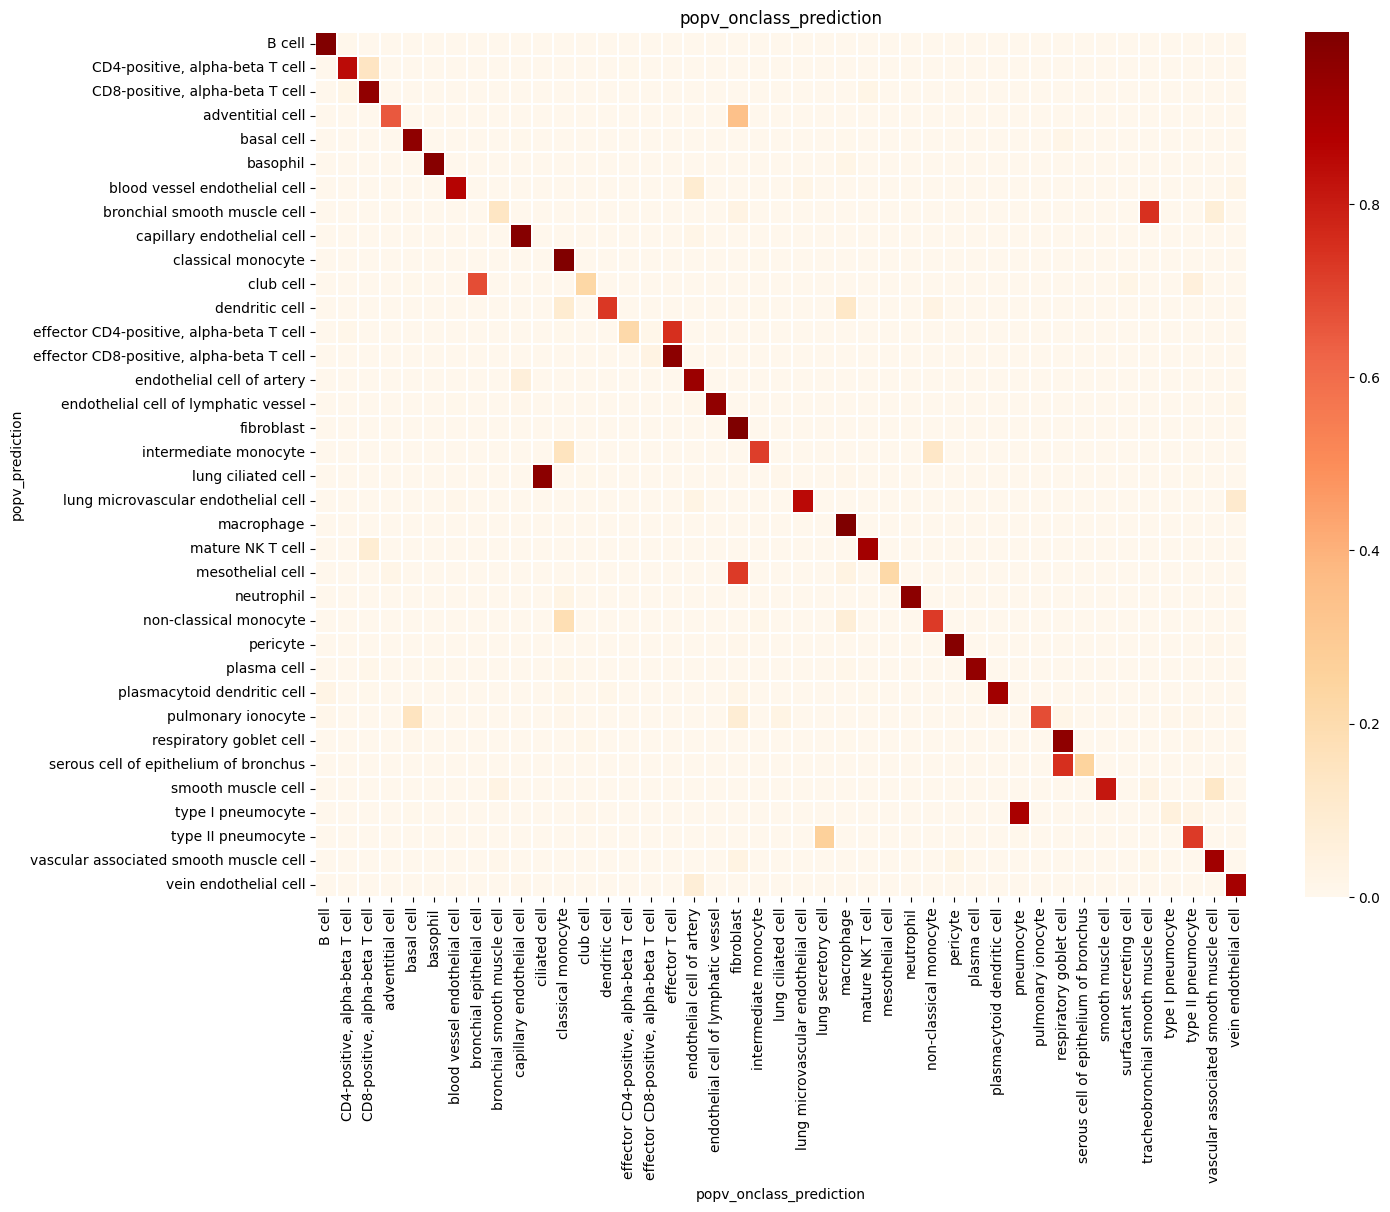

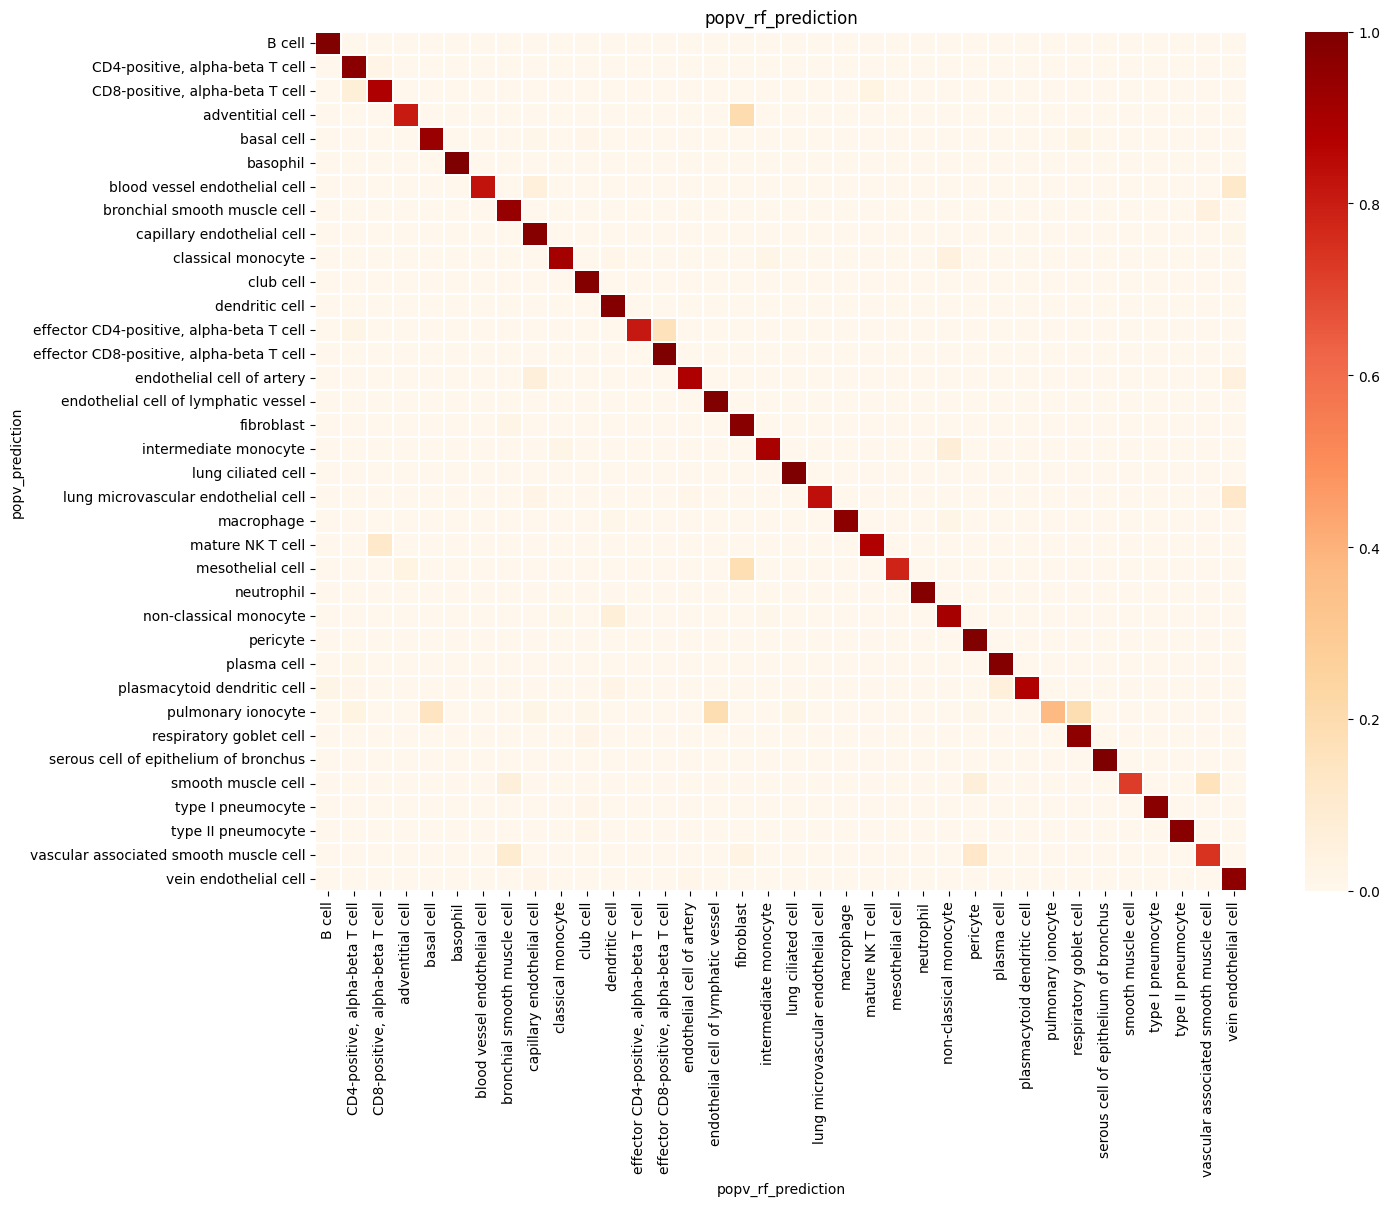

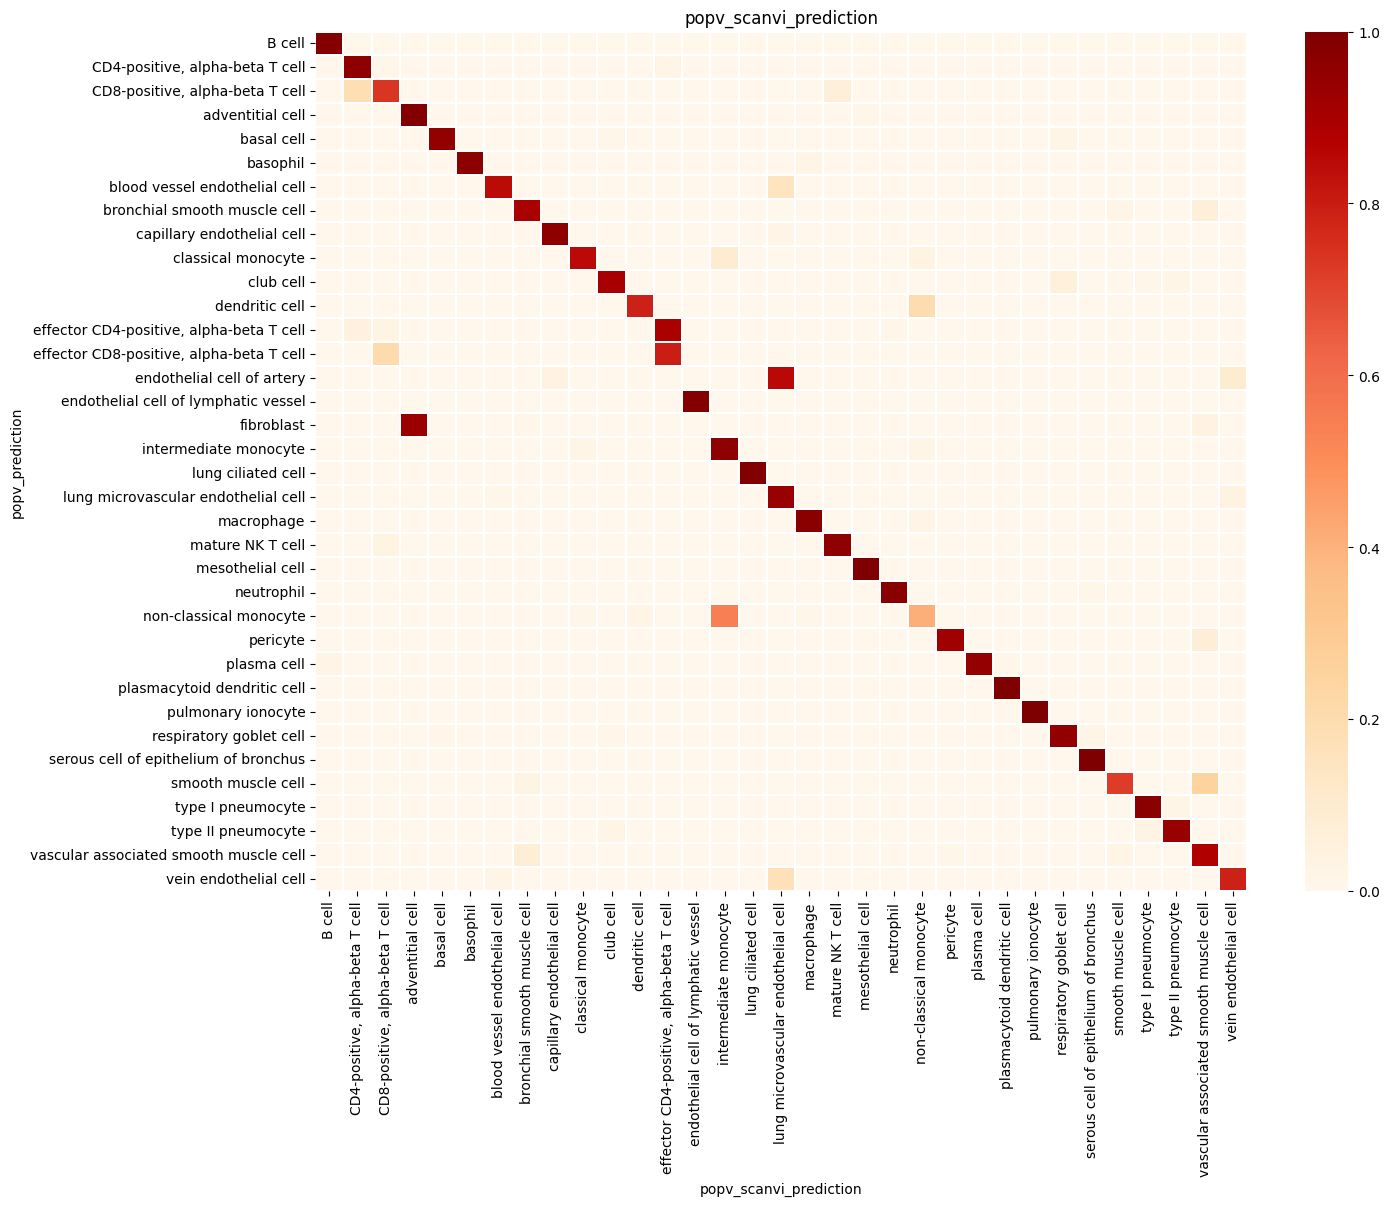

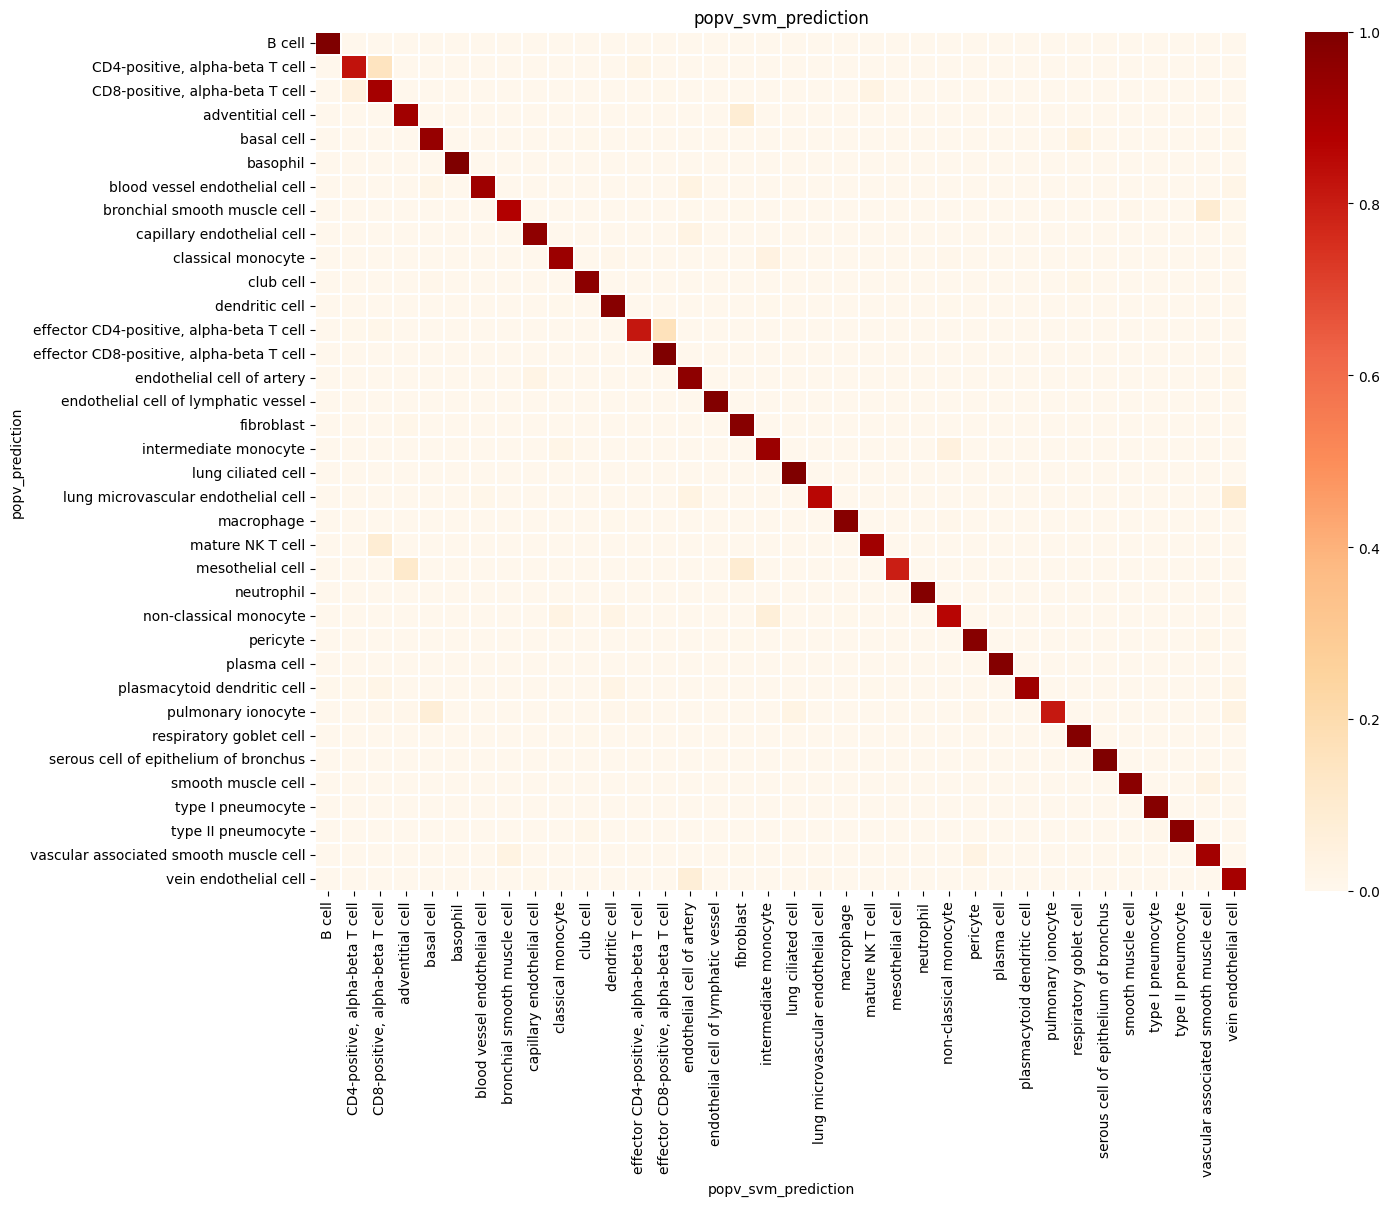

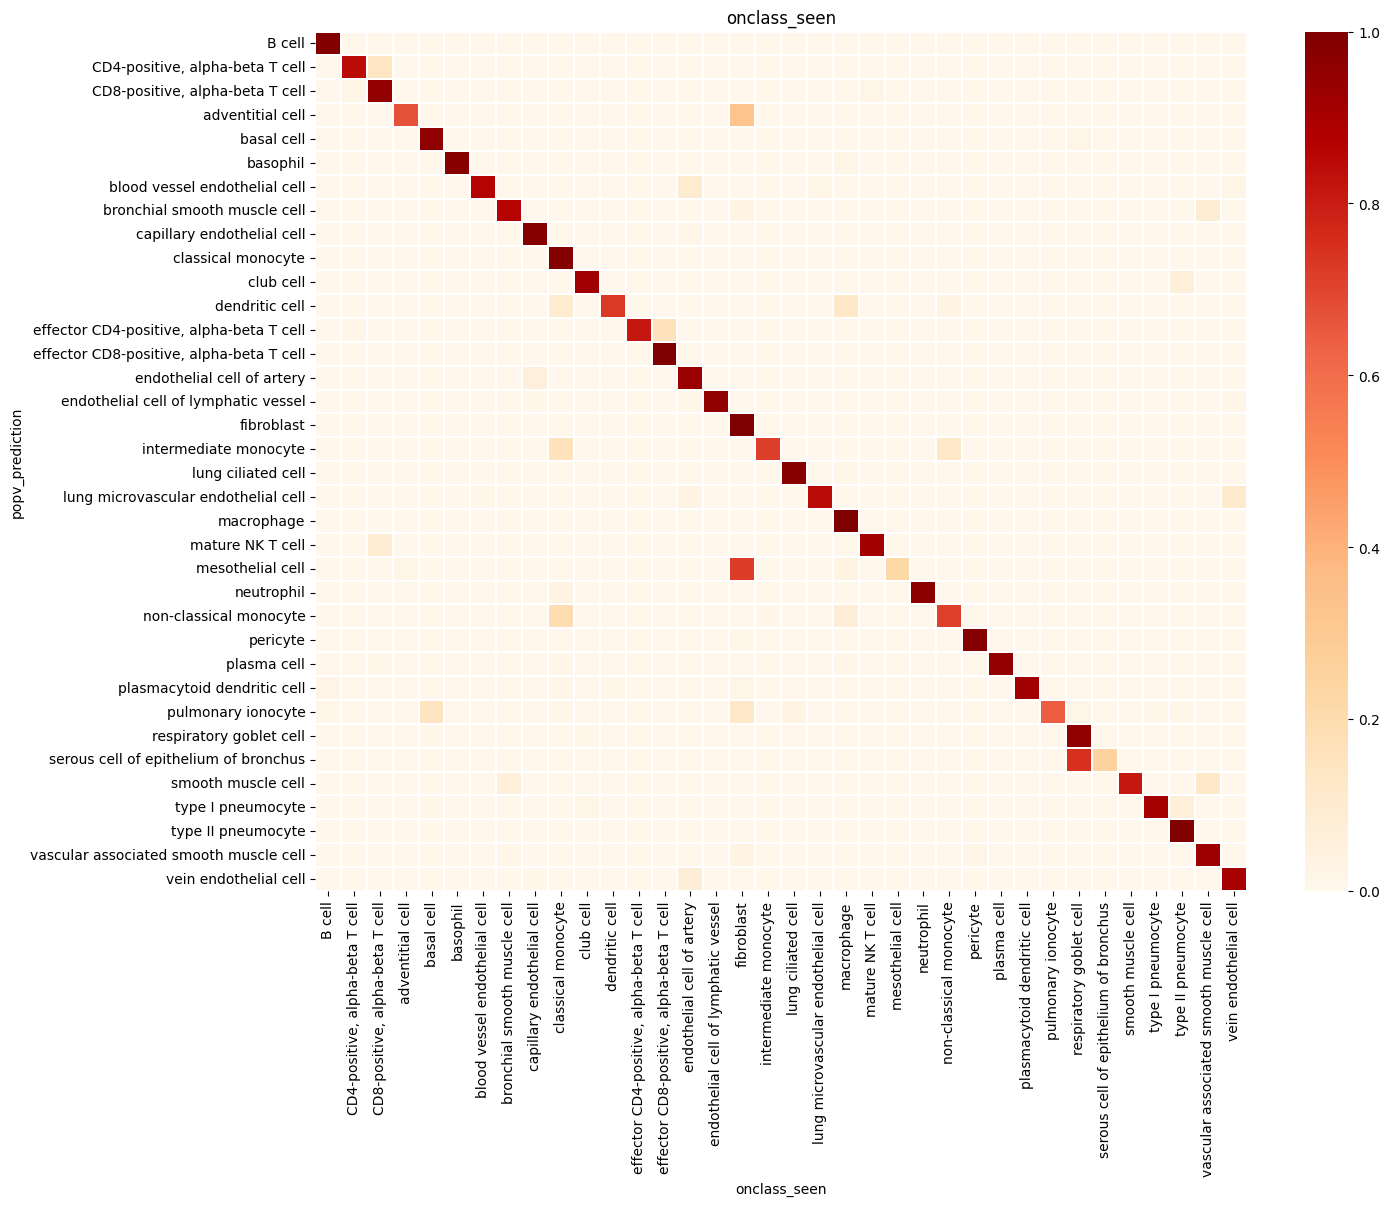

In [17]:
popv.visualization.make_agreement_plots(adata, prediction_keys=adata.uns['prediction_keys'] + ['onclass_seen'], save_folder=save_folder)

In [26]:
adata.write('tmp_testing/popv_predicted.h5ad')

In [4]:
adata = sc.read('tmp_testing/popv_predicted.h5ad')

<AxesSubplot: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

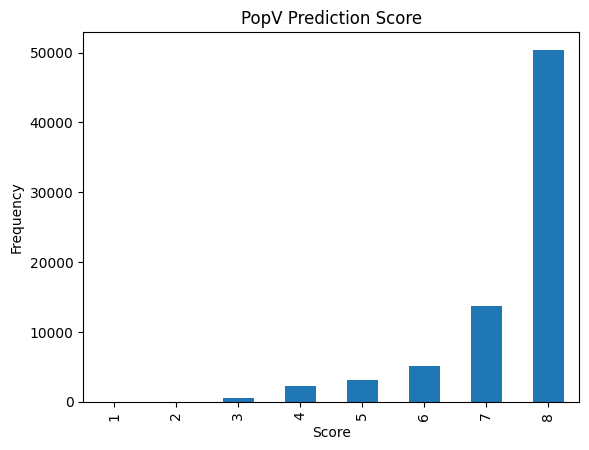

In [5]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_prediction_score")

<AxesSubplot: ylabel='Mean Agreement'>

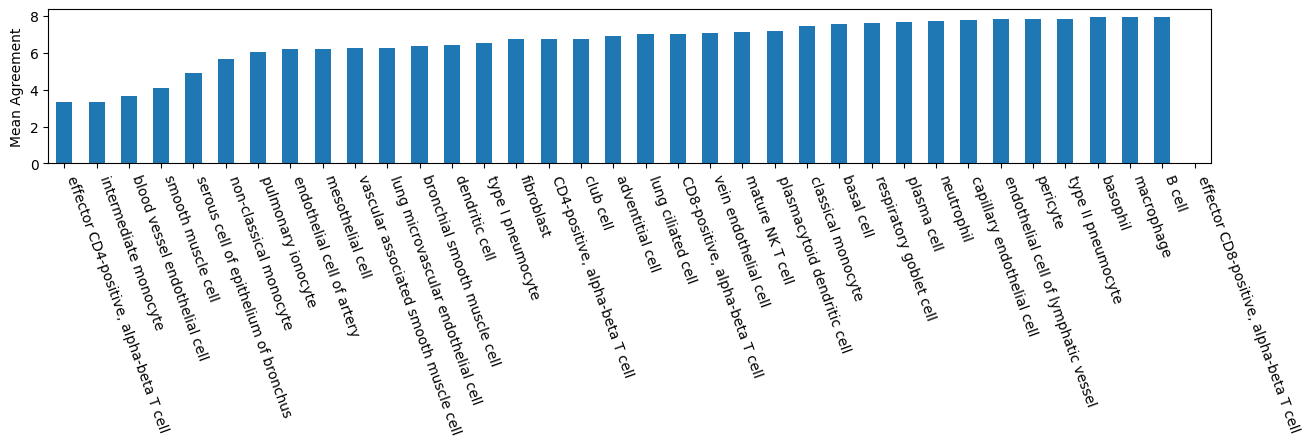

In [7]:
popv.visualization.agreement_score_bar_plot(adata)

In [15]:
popv_prediction_key = "popv_prediction"
consensus_score_key = "popv_prediction_score"

ct = adata.obs[popv_prediction_key]

celltypes = ct.unique()
mean_agreement = [
    np.mean(
        adata[
            np.logical_and(
                adata.obs["_dataset"] == "query",
                ct == x,
            )
        ]
        .obs[consensus_score_key]
        .astype(float)
    )
    for x in celltypes
]
mean_agreement = pd.DataFrame(
    [mean_agreement], index=["agreement"], columns=celltypes
).T
mean_agreement.dropna(inplace=True)

In [16]:
mean_agreement

,agreement
"CD4-positive, alpha-beta T cell",6.752827
macrophage,7.914596
type II pneumocyte,7.839654
capillary endothelial cell,7.762839
basophil,7.906533
plasma cell,7.663415
basal cell,7.534987
dendritic cell,6.439103
classical monocyte,7.436941
plasmacytoid dendritic cell,7.175676


### Cell type proportion plot

<AxesSubplot: ylabel='log Celltype Abundance'>

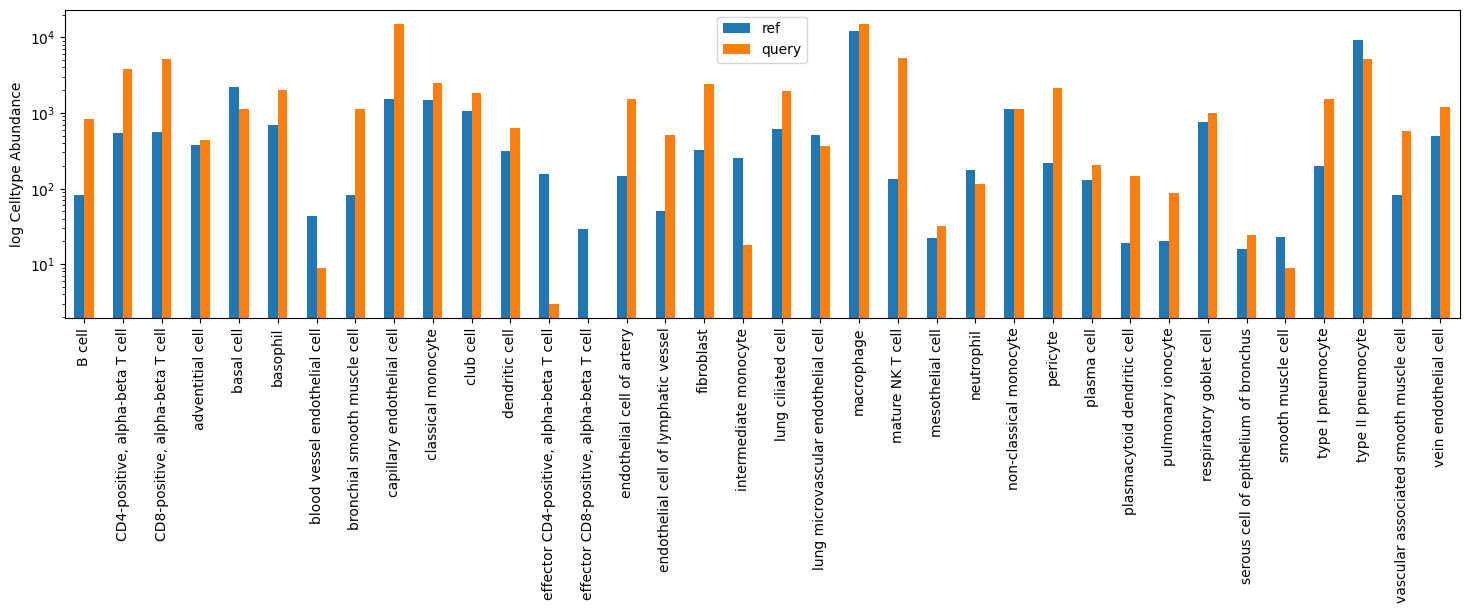

In [24]:
popv.visualization.celltype_ratio_bar_plot(adata)